In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# Data Cleaning

In [2]:
columns = ['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 'drive-wheels', 'engine-location', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-type', 'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']
cars = pd.read_csv('imports-85.data', names=columns)
print(cars.shape)
cars.head()

(205, 26)


,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


In [3]:
# We want to consider only the continuous/numeircal features in this case
continuous_features = ['normalized-losses', 'wheel-base', 'length', 'width', 
                      'height', 'curb-weight', 'bore', 'stroke', 'compression-ratio', 
                      'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']

cars_continuous = cars[continuous_features].copy()

After dropping the nominal features, we see where data is missing

In [4]:
print(cars_continuous.isnull().sum())

normalized-losses    0
wheel-base           0
length               0
width                0
height               0
curb-weight          0
bore                 0
stroke               0
compression-ratio    0
horsepower           0
peak-rpm             0
city-mpg             0
highway-mpg          0
price                0
dtype: int64


We notice that normalised-losses feature has "?" in it. We should try to replace such values since the dataset itself is small and we shoudl try to retain data as far as possible.

In [5]:
cars_continuous.replace('?', np.nan, inplace=True)
cars_continuous = cars_continuous.astype("float") 
# cars_continuous.dtypes

In [6]:
cars_continuous.isnull().sum()

normalized-losses    41
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
bore                  4
stroke                4
compression-ratio     0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 4
dtype: int64

In [7]:
cars_continuous = cars_continuous.fillna(cars_continuous.mean())
prices = cars_continuous['price']
# cars_continuous.isnull().sum()

In [8]:
normalized_cars = (cars_continuous-cars_continuous.mean())/(cars_continuous.max()-cars_continuous.min())
normalized_cars['price'] = prices

# Defining the KNN Regression Class

In [9]:
class KNNRegression:
    def __init__(self, n_neighbours):
        self.n_neighbours = n_neighbours
        self.train_set = []
        self.test_set = []
    
    def fit(self, train_set, target):
        self.train_set = train_set.to_numpy()
        self.target =  target.to_numpy()

    def predict(self, test_set):
        self.test_set = test_set.to_numpy()
#         print(self.train_set.shape, self.test_set.shape)
        predictions = []
        for i in range(len(self.test_set)):
            neighbours = []
            # Find distances
            for j in range(len(self.train_set)):
                dist = np.linalg.norm(self.test_set[i] - self.train_set[j])
                neighbours.append((dist, self.target[j]))
            # Find nearest neighbours
            nearest_neighbours = sorted(neighbours, key = lambda x : x[0])
            
            #Calculate average
            y_hat = 0.0
            for k in range(self.n_neighbours):
                y_hat += nearest_neighbours[k][1]
            y_hat = y_hat/self.n_neighbours
            predictions.append(y_hat)  
            
        return predictions

In [10]:
# Function for calculating Root Mean Squared Error
def RMSE(Y, Y_pred):
    rmse_np = np.sqrt(np.square(Y - Y_pred).mean())
    return rmse_np

# Q1 a. Vanilla KNN Model and Testing Multiple K values

In [11]:
def vanilla_knn(features, target_column, df, k):
     # Randomize order of rows in data frame.
    np.random.seed(1)
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)

    # Split the dataset
    train_set = rand_df.iloc[0:int(0.7*len(rand_df))]
    test_set = rand_df.iloc[int(0.7*len(rand_df)):]
    
    # Train
    knn = KNNRegression(k)
    knn.fit(train_set[features], train_set[target_column])
    
    # Predict
    predictions = knn.predict(test_set[features])
    
    # Calculate RMSE
    rmse = RMSE(test_set[target_column], predictions)
    
    return rmse
    

In [12]:
# Consider multiple values of k
k_values = []
for k in range(1,26):
    k_values.append(k)

vanilla_rmse = {}
target_column = 'price'

curr_rmse = []
for k in k_values:
    curr_rmse.append(vanilla_knn(continuous_features[0:-1], target_column, normalized_cars, k))

vanilla_rmse['all-numerical-features'] = curr_rmse
curr_rmse

[5074.399863284866,
 3995.0791474691705,
 3745.8372109910597,
 3870.4576822533995,
 4121.387326100853,
 4278.818985283127,
 4544.082824277029,
 4621.061233443938,
 4669.081936528378,
 4495.547883430654,
 4557.346855843029,
 4673.868649459902,
 4761.463550944061,
 4825.292085053326,
 4785.086496454591,
 4736.605778487467,
 4741.598823608981,
 4791.424643021847,
 4895.857186104777,
 4965.860740141817,
 4947.581257356546,
 4940.949642482179,
 4987.541074845277,
 4992.638840404373,
 4986.887722520526]

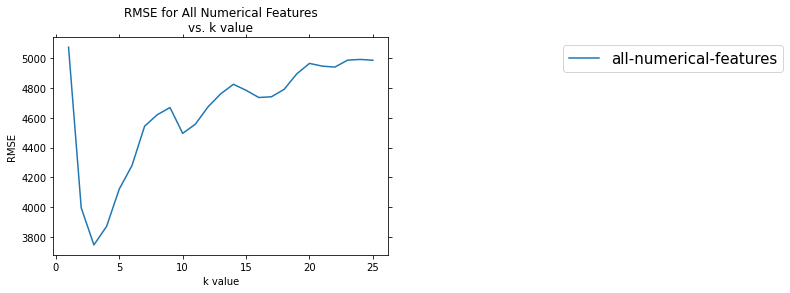

In [13]:
fig, ax = plt.subplots(1)

for key, values in vanilla_rmse.items():
    ax.plot(k_values, values, label=key)
    ax.set_xlabel('k value')
    ax.set_ylabel('RMSE')
    ax.set_title('RMSE for All Numerical Features\nvs. k value')
    ax.tick_params(top="off", left="off", right="off", bottom='off')
    ax.legend(bbox_to_anchor=(1.5, 1), prop={'size': 15})

## Results for Q1 b.
We caan notice that using cross-validation, the the best value of $k_{optimal} = 3$.  
The corresponding RMSE = 3745.8372109910597

# Introducing Greedy Strategy


Start with individual features

In [14]:
def knn_train_test_single_feature(feature, target_column, df, k):
    
    # Randomize order of rows in data frame.
    np.random.seed(1)
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)

    # Split the dataset
    train_set = rand_df.iloc[0:int(0.7*len(rand_df))]
    test_set = rand_df.iloc[int(0.7*len(rand_df)):]
    
    # Train
    knn = KNNRegression(k)
    knn.fit(train_set[[feature]], train_set[target_column])
    
    # Predict
    predictions = knn.predict(test_set[[feature]])
    
    # Calculate RMSE
    rmse_np = RMSE(test_set[target_column], predictions)
    
    return rmse_np

In [15]:
# We try to use only a single feature and see which one gives best results
k_values = range(1,25)
rmse_single_feature = {} # stores rmse for k values corresponding to each feature
current_rmse = []
target_column = 'price'

for feature in continuous_features[0:-1]:
    for k in k_values:
        current_rmse.append(knn_train_test_single_feature(feature, target_column, normalized_cars, k))
        
    rmse_single_feature[feature] = current_rmse
    current_rmse = []

# rmse_single_feature

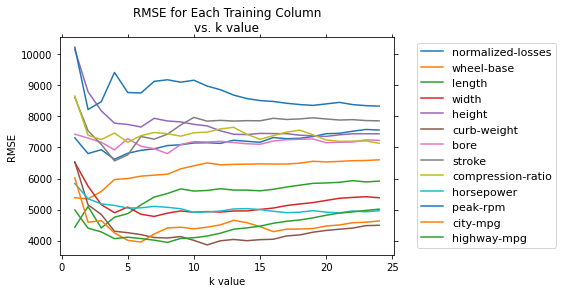

In [16]:
fig, ax = plt.subplots(1)

for key, values in rmse_single_feature.items():
    ax.plot(k_values, values, label=key)
    ax.set_xlabel('k value')
    ax.set_ylabel('RMSE')
    ax.set_title('RMSE for Each Training Column\nvs. k value')
    ax.tick_params(top="off", left="off", right="off", bottom='off')
    ax.legend(bbox_to_anchor=(1.5, 1), prop={'size': 11})

## Sort the features according to minimum average RMSE

In [17]:
average_rmse_single_feature = {}

for key, value in rmse_single_feature.items():
    average_rmse_single_feature[key] = np.mean(value)
# print(average_rmse_single_feature)

best_features = sorted(average_rmse_single_feature, key = average_rmse_single_feature.get)
average_rmse_single_feature = pd.Series(average_rmse_single_feature)
best_features

['curb-weight',
 'highway-mpg',
 'city-mpg',
 'horsepower',
 'width',
 'length',
 'wheel-base',
 'bore',
 'normalized-losses',
 'compression-ratio',
 'stroke',
 'height',
 'peak-rpm']

### Greedily consider multiple best features
We can consider the best feature, the best 2 features and so on and see which combination gives us the best results.

In [18]:
top_features = {}
for t in range(1, len(best_features)+1):
    s = 'top_' + str(t)
    top_features[s] = best_features[0:t]
for key, values in top_features.items():
    print(key, values)

top_1 ['curb-weight']
top_2 ['curb-weight', 'highway-mpg']
top_3 ['curb-weight', 'highway-mpg', 'city-mpg']
top_4 ['curb-weight', 'highway-mpg', 'city-mpg', 'horsepower']
top_5 ['curb-weight', 'highway-mpg', 'city-mpg', 'horsepower', 'width']
top_6 ['curb-weight', 'highway-mpg', 'city-mpg', 'horsepower', 'width', 'length']
top_7 ['curb-weight', 'highway-mpg', 'city-mpg', 'horsepower', 'width', 'length', 'wheel-base']
top_8 ['curb-weight', 'highway-mpg', 'city-mpg', 'horsepower', 'width', 'length', 'wheel-base', 'bore']
top_9 ['curb-weight', 'highway-mpg', 'city-mpg', 'horsepower', 'width', 'length', 'wheel-base', 'bore', 'normalized-losses']
top_10 ['curb-weight', 'highway-mpg', 'city-mpg', 'horsepower', 'width', 'length', 'wheel-base', 'bore', 'normalized-losses', 'compression-ratio']
top_11 ['curb-weight', 'highway-mpg', 'city-mpg', 'horsepower', 'width', 'length', 'wheel-base', 'bore', 'normalized-losses', 'compression-ratio', 'stroke']
top_12 ['curb-weight', 'highway-mpg', 'city-mp

In [19]:
# Multivariate model
def knn_train_test_multiple_features(features, target_column, df, k):
    
    # Randomize order of rows in data frame.
    np.random.seed(1)
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)

    # Split the dataset (70-30)
    train_set = rand_df.iloc[0:int(0.7*len(rand_df))]
    test_set = rand_df.iloc[int(0.7*len(rand_df)):]
    
    # Train
    model = KNNRegression(k)
    model.fit(train_set[features], train_set[target_column])
    
    # Predict
    predictions = model.predict(test_set[features])
    
    # Calculate RMSE
    rmse = RMSE(test_set[target_column], predictions)
    
    return rmse

In [20]:
rmse_multi = {}
target_column = 'price'
k_values = range(1,26)

for key, value in top_features.items():
    current_rmse = []
    for k in k_values:
        current_rmse.append(knn_train_test_multiple_features(value, target_column, normalized_cars, k))
    rmse_multi[key] = current_rmse

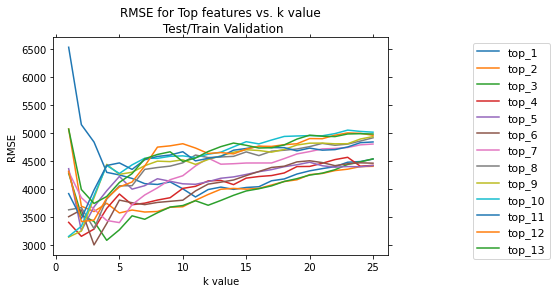

In [21]:
# Plot results
fig, ax = plt.subplots(1)

for key, values in rmse_multi.items():
    ax.plot(k_values, values, label=key)
    ax.set_xlabel('k value')
    ax.set_ylabel('RMSE')
    ax.set_title('RMSE for Top features vs. k value\n Test/Train Validation')
    ax.tick_params(top="off", left="off", right="off", bottom='off')
    ax.legend(bbox_to_anchor=(1.5, 1), prop={'size': 11})

In [22]:
# Function to find the best k parameter for 'top n' features
def get_best_k(multi_rmse):
    best_k_values = {}
    for k, rmse in multi_rmse.items():
        best_k_values[k] = (min(rmse), rmse.index(min(rmse)))
    return best_k_values

In [23]:
best_params = get_best_k(rmse_multi)
best_params

{'top_1': (3861.9603074317783, 10),
 'top_2': (3576.08955019711, 4),
 'top_3': (3087.4342145551136, 3),
 'top_4': (3158.9522969650425, 1),
 'top_5': (3258.1185919832274, 1),
 'top_6': (3005.045431656457, 2),
 'top_7': (3403.63420344319, 4),
 'top_8': (3296.1799195868975, 2),
 'top_9': (3145.0339408400228, 0),
 'top_10': (3157.260670367372, 0),
 'top_11': (3474.5055701070187, 1),
 'top_12': (3422.134404614854, 1),
 'top_13': (3745.8372109910597, 2)}

We can notice that the 'top_6' gives the best performance till now.   
top_6 ['curb-weight', 'highway-mpg', 'city-mpg', 'horsepower', 'width', 'length'].  

This can be considered as a building block towards the next part as well. The current idea was to see which features are important individually. A greedy and simple heuristic might be to consider the top $n$ best features and use them for prediction. This is what we have calculated above. 

## Another result for Q1 b
This slightly more intelligent method gives us a KNN model which uses 6 features and the optimal k = 2.  


# Q1 c) Introducing $L_0$ Regularisation

Adding an $L_0$ regularisation is penalising non-zero weights.  
$L(\textbf{w}) = RMSE + \lambda*count(\textbf{w})$ where $count(\textbf{w})$ gives number of non-zero weights in $\textbf{w}$. 

$L_0$ is a stronger way of making weights sparse (discarding less essential features). This is the essential idea we'll use to justify the code ahead

### KNN and the Curse of Dimensionality
This is a common problem with KNN as the number of features become larger. The issue is that when the dimension $d$ is large, then the notion of "closeness" of points in the space breaks down. Even to get a few "nearest points", one would have to sample a really large volume in the higher dimensional space.   

In very simple (not mathematically rigorous terms), almost all the data seems to be equidistant from a point in higher dimensional space. 

Reference : https://www.youtube.com/watch?v=dZrGXYty3qc

### Jumping over the Gradients
We make use of the Euclidean Distance in the KNN. So the distance of a test point is given as   
$d_i^2 = \sum_{d}w_d*(x_d - x^i_d)^2$   ($x^i$ is the $i^{th}$ data point in training set)  
where $w_d$ is the weight of the $d^{th}$ feature.  

Now, with $L_0$ we want to make these $w_d$ zero. But $w_d$ is only considered to be 1 or 0 here. So in that case, the regularisation term doesn't really give us much information about what weights to reduce. It just seems like a brute force search over all possible features which isn't a fast solution.   

We need a better way to think about removing features

We know that $L_0$ regularisation is about removing less essential features and that's the idea we'll use to get a somewhat efficient solution to this regularisation problem rather than getting into gradients.  

We found best individual features in the part above and building up on that will be the way forward. 

### BACKWARD SEARCH
Start with all the features.  
Remove the feature which reduces RMSE the most. 

### FORWARD SEARCH
Start with 0 features.  
Keep adding the one which gives least error.

Backward Search seems more intuitive since we're removing bad features from the whole set but given the curse of dimensionality issue with KNN, it might be tough to distinguish bad features when already a lot of features are present.  

Therefore the Forward Search method has been implemented

In [24]:
########################################## FORWARD SEARCH #####################################
possible_features = ['normalized-losses', 'wheel-base', 'length', 'width', 
                      'height', 'curb-weight', 'bore', 'stroke', 'compression-ratio', 
                      'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg']

k_values = range(1,26)
target_column = 'price'

rmse_forward_search = {}

def forward_search(possible_features, target_column, df, k ):
    greedy_feat = []
    best_err = float('inf')
    best_feats = []
    possible_feat = possible_features.copy()
    
    for i in range(len(possible_features)):
        best_error_for_i = float('inf')
        best_f = ""
        # finds the best feature to append to the set
        for f in possible_feat:
            temp_feat = greedy_feat.copy()
            temp_feat.append(f)
            rmse = knn_train_test_multiple_features(temp_feat, target_column, df, k)
            if(rmse < best_error_for_i):
                best_error_for_i = rmse
                best_f = f 
        
        greedy_feat.append(best_f)
        possible_feat.pop(possible_feat.index(best_f))
#         print(best_error_for_i, greedy_feat)
        if(best_error_for_i < best_err):
            best_err = best_error_for_i
            best_feats = greedy_feat.copy()
    # returns the overall best features 
    return (best_err, best_feats)
                
# Need to test for multiple k values
for k in k_values:
    rmse_forward_search[k] = forward_search(possible_features, target_column, normalized_cars, k)
    print("K = ", k, rmse_forward_search[k])

K =  1 (2931.10940771638, ['length', 'curb-weight', 'bore'])
K =  2 (2403.7957630296432, ['highway-mpg', 'peak-rpm', 'curb-weight', 'bore', 'compression-ratio'])
K =  3 (2463.255341082316, ['highway-mpg', 'peak-rpm', 'curb-weight', 'stroke', 'compression-ratio'])
K =  4 (2757.4179048740557, ['highway-mpg', 'curb-weight', 'compression-ratio', 'peak-rpm', 'stroke'])
K =  5 (3051.7017008208077, ['city-mpg', 'curb-weight', 'compression-ratio', 'highway-mpg', 'width'])
K =  6 (3126.7721374557095, ['city-mpg', 'curb-weight', 'compression-ratio', 'bore', 'highway-mpg'])
K =  7 (3256.2178139719204, ['highway-mpg', 'curb-weight', 'compression-ratio'])
K =  8 (3287.8026226516968, ['highway-mpg', 'curb-weight', 'compression-ratio', 'city-mpg', 'bore'])
K =  9 (3262.0153072969556, ['highway-mpg', 'horsepower', 'compression-ratio', 'city-mpg', 'peak-rpm', 'curb-weight', 'width'])
K =  10 (3299.3198185250226, ['curb-weight', 'peak-rpm', 'highway-mpg', 'horsepower', 'width', 'city-mpg'])
K =  11 (345

## Results for Q1 c)
The $L_0$ regularisation gives better results.  
The best result is to use the features : 
['highway-mpg', 'peak-rpm', 'curb-weight', 'bore', 'compression-ratio']  
and $k = 2$

# Q1 d) Generalizations
Since this is KNN, improving the loss on validation set gives us confidence about better generalizations (compared to the !3700 error on the naive model and ~3000 error on the simple greedy model)  

Making use of the existing best features incase while searching for the next best feature to add made it more informed than the simple greedy heuristic used earlier. 


### Explanation of results
The greedy strategy used earlier gave us the following features :   
top_6 ['curb-weight', 'highway-mpg', 'city-mpg', 'horsepower', 'width', 'length']

curb-weight seemed important since it could be an indicator of the materials used. mpg and horsepower is generally an important factor as it related to the engine. width and length might again be an indicator of the materials and bulk but it's possible these features might've made it only because of the greedy strategy. 

The Forward Search gave us the following features:
['highway-mpg', 'peak-rpm', 'curb-weight', 'bore', 'compression-ratio']

Some features like highway-mpg and curb-weight match but this set seems more informative than the previous ones. Either one of the highway-mpg or city-mpg might be enough and having both is probably redundant. curb weight comes again.  
But the other features are different. peak-rpm, bore and compression ration give much more information related to the power, mileage and effieciency of the car implicitly.  
These were added later on since the curb-weight was already present and would've provided enough information related to the physical features and so length and width wouldn't have improved the performance much

# Q2. Decision Trees

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Data Cleaning

In [26]:
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education.num', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'capital.gain', 'capital.loss', 'hours.per.week', 'native.country', 'income']
df = pd.read_csv('adult.data', names=columns)
print(df.shape)
df.head()

(32561, 15)


,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [27]:
print ("Unique values :\n",df.nunique())
print ("\nMissing values :  ", df.isnull().sum().values.sum())

Unique values :
 age                  73
workclass             9
fnlwgt            21648
education            16
education.num        16
marital.status        7
occupation           15
relationship          6
race                  5
sex                   2
capital.gain        119
capital.loss         92
hours.per.week       94
native.country       42
income                2
dtype: int64

Missing values :   0


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [29]:
df.describe()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


We choose to remove all the rows which have these missing values.  
Since the dataset is pretty big, removal of these points is alright

In [30]:
df_missing = (df==' ?').sum()
df_missing

age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
income               0
dtype: int64

In [31]:
df = df[df['workclass'] != " ?"]
df_missing = (df==' ?').sum()
print(df.shape)
df_missing

(30725, 15)


age                 0
workclass           0
fnlwgt              0
education           0
education.num       0
marital.status      0
occupation          7
relationship        0
race                0
sex                 0
capital.gain        0
capital.loss        0
hours.per.week      0
native.country    556
income              0
dtype: int64

In [32]:
df = df[df['occupation'] != ' ?']
df_missing = (df==' ?').sum()
print(df.shape)
df_missing

(30718, 15)


age                 0
workclass           0
fnlwgt              0
education           0
education.num       0
marital.status      0
occupation          0
relationship        0
race                0
sex                 0
capital.gain        0
capital.loss        0
hours.per.week      0
native.country    556
income              0
dtype: int64

In [33]:
df = df[df['native.country'] != ' ?']
df_missing = (df==' ?').sum()
print(df.shape)
df_missing

(30162, 15)


age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

In [34]:
# select all categorical variables
df_categorical = df.select_dtypes(include=['object'])

# checking whether any other column contains '?' value
print(df_categorical.apply(lambda x: x==' ?',axis=1).sum())
print(df_categorical.shape)

workclass         0
education         0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
native.country    0
income            0
dtype: int64
(30162, 9)


In [35]:
print(df_categorical.shape)
df_categorical.head()

(30162, 9)


,workclass,education,marital.status,occupation,relationship,race,sex,native.country,income
0,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,United-States,<=50K
1,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,<=50K
2,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States,<=50K
3,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States,<=50K
4,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba,<=50K


Converting categorical values to numbers

In [36]:
df_categorical.columns
categorical_columns = ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country', 'income']
df_categorical = df_categorical.astype("category")
for cat_feat in categorical_columns:
    df_categorical[cat_feat] = df_categorical[cat_feat].cat.codes
# df_categorical['workclass'] = df_categorical['workclass'].cat.codes

df_categorical.head()

,workclass,education,marital.status,occupation,relationship,race,sex,native.country,income
0,5,9,4,0,1,4,1,38,0
1,4,9,2,3,0,4,1,38,0
2,2,11,0,5,1,4,1,38,0
3,2,1,2,5,0,2,1,38,0
4,2,9,2,9,5,2,0,4,0


In [37]:
for index, row in df_categorical.iterrows():
    if(row['income']==0):
        row['income'] = -1

In [38]:
df_categorical.head(10)

,workclass,education,marital.status,occupation,relationship,race,sex,native.country,income
0,5,9,4,0,1,4,1,38,-1
1,4,9,2,3,0,4,1,38,-1
2,2,11,0,5,1,4,1,38,-1
3,2,1,2,5,0,2,1,38,-1
4,2,9,2,9,5,2,0,4,-1
5,2,12,2,3,5,4,0,38,-1
6,2,6,3,7,1,2,0,22,-1
7,4,11,2,3,0,4,1,38,1
8,2,12,4,9,1,4,0,38,1
9,2,9,2,3,0,4,1,38,1


## Decision Tree Class

Code Credits : Prof. Purushottam Kar

In [39]:
class Node:
    # A node stores its own depth (root = depth 0), its decision stump, its parent and child information
    # Leaf nodes also store a constant label that is assigned to every data point that reaches that leaf
    def __init__( self, depth = 0, stump = (0,0), parent = None ):
        self.depth = depth
        self.stump = stump
        self.parent = parent
        self.left = None
        self.right = None
        self.isLeaf = True
        self.label = 0
        
    def predict( self, data ):
        # If I am a leaf I can predict rightaway
        # May change this constant leaf action to something more interesting and powerful
        if self.isLeaf:
            return self.label
        # Else I have to ask one of my children to do the job
        else:
            if data[self.stump[0]] > self.stump[1]:
                return self.right.predict( data )
            else:
                return self.left.predict( data )
            
    # Get the Gini coefficient of a node with nPos positive points and nNeg negative points
    def getGini( self, nPos, nNeg ):
        nTot = nPos + nNeg
        # Find the proportion of the positives and negatives in that node
        pPos = nPos/nTot
        pNeg = nNeg/nTot
        # The gini index is always a real number between 0 and 0.5
        # A perfectly pure node has gini index = 0
        # The smaller the gini index the purer the node
        gini = 1 - (pPos**2 + pNeg**2)
        return gini
    
    def getEntropy(self, nPos, nNeg):
        nTot = nPos + nNeg
        
        pPos = nPos/nTot
        pNeg = nNeg/nTot
        
        ans = 0.0
        if nPos >0:
            ans += pPos*np.log2(pPos)
        
        if nNeg > 0:
            ans += pNeg*np.log2(pNeg)
        
        return -ans
        
            
    def getStump( self, X, y ):
        # How many data points do I have at this node?
        n = y.size
        bestObjective = float('inf')
        bestInformationGain = -float('inf')
        
        # For each of the features in the data
        for i in range( X.shape[1] ):
            # Do not use the same feature as used by the parent node
            if self.parent is not None and i == self.parent.stump[0]:
                continue
            # Find out all values at which we can threshold that feature
            candidateThresholds = np.sort( X[:, i] )
            idx = np.argsort( X[:, i] )
            # The cumulative sum trick used here will work only if labels are binary 
            ySorted = y[idx]
            yCum = np.cumsum( ySorted )
            yCumRev = np.cumsum( ySorted[::-1] )[::-1]
            
            # Current entropy
            nPos = (y>0).sum()
            nNeg = (y<0).sum()
            HS = self.getEntropy(nPos, nNeg)
            
            # For each possible threshold (except the ones at the extreme)
            for j in range( 1, candidateThresholds.size-1 ):
                # Give 0.5 weight to balance and 1 weight to purity of the two nodes
#                 candidateObjective = 0.0 * 0.0 \
#                                     + 1.0 * self.getGini( (yCum[j] + j+1)/2, (j+1 - yCum[j])/2 ) \
#                                     + 1.0 * self.getGini( (yCumRev[j+1] + n-j-1)/2, (n-j-1 - yCumRev[j+1])/2 )

                # Compute entropy for each node and then calculate information gain
                nPos1 = (yCum[j] + j + 1)/2
                nNeg1 = (j + 1 - yCum[j])/2
        
                nPos2 = (yCumRev[j+1] + n-j-1)/2
                nNeg2 = (n-j-1 - yCumRev[j+1])/2
                informationGain = HS - ((nPos1+nNeg1)/(nPos + nNeg))*self.getEntropy(nPos1, nNeg1) - ((nPos2 + nNeg2)/(nPos + nNeg))*self.getEntropy(nPos2, nNeg2)                
                    
#                 if candidateObjective < bestObjective:
#                     bestObjective = candidateObjective
#                     bestFeat = i
#                     bestThresh = candidateThresholds[j]
                if (informationGain > bestInformationGain):
                    bestInformationGain = informationGain
                    bestFeat = i
                    bestThresh = candidateThresholds[j]
                      
        
        # Can try LwP decision stump as well
        bestThresh = (np.mean(X[y > 0, bestFeat]) + np.mean(X[y < 0, bestFeat]))/2
        return (bestFeat, bestThresh)
            
    def train( self, X, y, maxLeafSize, maxDepth ):
        # If too few data points are present, or else if this node is too deep in the tree, make this a leaf
        if y.size < maxLeafSize or self.depth >= maxDepth:
            self.isLeaf = True
            # Give label of 1 or -1
            if(np.mean(y) > 0):
                self.label = 1
            else:
                self.label = -1
#             self.label = np.mean(y)
        else:
            # This node will be split and hence it is not a leaf
            self.isLeaf = False
            # Get the best possible decision stump
            self.stump = self.getStump( X, y )
            self.left = Node( depth = self.depth + 1, parent = self )
            self.right = Node( depth = self.depth + 1, parent = self )
            # Find which points go to my left child and which go to my right child
            discriminant = X[:, self.stump[0]] - self.stump[1]
            # Train my two children recursively
            self.left.train( X[discriminant <= 0, :], y[discriminant <= 0], maxLeafSize, maxDepth )
            self.right.train( X[discriminant > 0, :], y[discriminant > 0], maxLeafSize, maxDepth )

In [40]:
class Tree:
    def __init__( self, maxLeafSize = 10, maxDepth = 5 ):
        self.root = Node()
        self.maxLeafSize = maxLeafSize
        self.maxDepth = maxDepth 
        
    def predict( self, xt ):
        predictions = []
        for i in range(xt.shape[0]):
#             print(xt[i].shape)
            predictions.append(self.root.predict(xt[i]))
        return predictions
    
    def train( self, X, y):
        self.root.train( X, y, self.maxLeafSize, self.maxDepth )

## Q2 a) Running Decision Trees on the data 

In [42]:
# If thre is some kind of warning, just run the cell again

DT = Tree( maxLeafSize = 10, maxDepth = 8 )
categorical_columns = ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country', 'income']

# Randomize order of rows in data frame.
np.random.seed(1)
shuffled_index = np.random.permutation(df_categorical.index)
rand_df = df_categorical.reindex(shuffled_index)

# Split the dataset
train_set = rand_df.iloc[0:int(0.8*len(rand_df))]
test_set = rand_df.iloc[int(0.8*len(rand_df)):]

X = train_set[categorical_columns[0:-1]].to_numpy()
y = train_set['income'].to_numpy()

DT.train( X, y )

In [43]:
xt = test_set[categorical_columns[0:-1]].to_numpy()
yt = test_set['income'].to_numpy()
pred = DT.predict(xt)

In [45]:
# pred
correct = 0
wrong = 0
for i in range(len(pred)):
#     correct += 1
    if(pred[i]==yt[i]):
        correct += 1
    else:
        wrong += 1
print(correct, wrong)
print(correct/(correct+wrong))

4857 1176
0.8050721034311288


## Q2b) Performing Cross Validation for Hyperparameter Tuning

In [46]:
def DT_train_test(maxLeafSize, maxDepth, categorical_columns, df_categorical):
    DT = Tree( maxLeafSize, maxDepth )
#     categorical_columns = ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country', 'income']

    # Randomize order of rows in data frame.
    np.random.seed(1)
    shuffled_index = np.random.permutation(df_categorical.index)
    rand_df = df_categorical.reindex(shuffled_index)

    # Split the dataset
    train_set = rand_df.iloc[0:int(0.8*len(rand_df))]
    test_set = rand_df.iloc[int(0.8*len(rand_df)):]

    # Do not consider price as feature
    X = train_set[categorical_columns[0:-1]].to_numpy()
    y = train_set['income'].to_numpy()

    DT.train( X, y )
    
    xt = test_set[categorical_columns[0:-1]].to_numpy()
    yt = test_set['income'].to_numpy()
    pred = DT.predict(xt)
    
    correct = 0
    for i in range(len(pred)):
        if(pred[i]==yt[i]):
            correct+=1
    return correct/len(pred)
    

In [47]:
best_accuracy = 0
best_params = []

for max_leaf_size in range(5, 20, 5):
    for max_depth in range(1,15):
        acc = DT_train_test(max_leaf_size, max_depth, categorical_columns, df_categorical)
#         print("MaxLeafSize : %d , MaxDepth : %d, Accuracy : %f " (max_leaf_size, max_depth, acc))
        print(max_leaf_size, max_depth, acc)
        if acc > best_accuracy:
            best_accuracy = acc
            best_params = (max_leaf_size, max_depth)

5 1 0.7434112381899552
5 2 0.7434112381899552
5 3 0.7434112381899552
5 4 0.7444057682744903
5 5 0.753522294049395
5 6 0.7903199071771921
5 7 0.7909829272335488
5 8 0.8050721034311288
5 9 0.8092159787833582
5 10 0.8077241836565556
5 11 0.8067296535720205
5 12 0.8085529587270015
5 13 0.8082214486988232
5 14 0.8077241836565556
10 1 0.7434112381899552
10 2 0.7434112381899552
10 3 0.7434112381899552
10 4 0.7444057682744903
10 5 0.753522294049395
10 6 0.7903199071771921
10 7 0.7909829272335488
10 8 0.8050721034311288
10 9 0.8102105088678933
10 10 0.8085529587270015
10 11 0.8083872037129123
10 12 0.8105420188960716
10 13 0.8105420188960716
10 14 0.8097132438256257
15 1 0.7434112381899552
15 2 0.7434112381899552
15 3 0.7434112381899552
15 4 0.7444057682744903
15 5 0.753522294049395
15 6 0.7903199071771921
15 7 0.7909829272335488
15 8 0.8050721034311288
15 9 0.8107077739101608
15 10 0.8092159787833582
15 11 0.8092159787833582
15 12 0.8110392839383391
15 13 0.8107077739101608
15 14 0.80987899883

In [48]:
best_params

(15, 12)

In [49]:
best_accuracy

0.8110392839383391

## Q2 c) Using LwP for decision stumps

Code credits : Prof. Purushottam Kar

In [50]:
class NodeLWP:
    # A node stores its own depth (root = depth 0), its decision stump, its parent and child information
    # Leaf nodes also store a constant label that is assigned to every data point that reaches that leaf
    def __init__( self, depth = 0, stump = (0,0), parent = None ):
        self.depth = depth
        self.stump = stump
        self.parent = parent
        self.left = None
        self.right = None
        self.isLeaf = True
        self.label = 0
        
    def predict( self, data ):
        # If I am a leaf I can predict rightaway
        # May change this constant leaf action to something more interesting and powerful
        if self.isLeaf:
            return self.label
        # Else I have to ask one of my children to do the job
        else:
            dist_p = np.linalg.norm(data - self.stump[0])
            dist_n = np.linalg.norm(data - self.stump[1])
            if dist_p < dist_n:
                return self.left.predict(data)
            else:
                return self.right.predict(data)
                
#             if data[self.stump[0]] > self.stump[1]:
#                 return self.right.predict( data )
#             else:
#                 return self.left.predict( data )
            
    # Get the Gini coefficient of a node with nPos positive points and nNeg negative points
    def getGini( self, nPos, nNeg ):
        nTot = nPos + nNeg
        # Find the proportion of the positives and negatives in that node
        pPos = nPos/nTot
        pNeg = nNeg/nTot
        # The gini index is always a real number between 0 and 0.5
        # A perfectly pure node has gini index = 0
        # The smaller the gini index the purer the node
        gini = 1 - (pPos**2 + pNeg**2)
        return gini
    
    def getEntropy(self, nPos, nNeg):
        nTot = nPos + nNeg
        
        pPos = nPos/nTot
        pNeg = nNeg/nTot
        
        ans = 0.0
        if nPos >0:
            ans += pPos*np.log2(pPos)
        
        if nNeg > 0:
            ans += pNeg*np.log2(pNeg)
        
        return -ans
        
            
    def getStump( self, X, y ):
        # How many data points do I have at this node?
        n = y.size
        bestObjective = float('inf')
        bestInformationGain = -float('inf')
        
        # For each of the features in the data
        for i in range( X.shape[1] ):
            # We don't need to run this loop
            break
            # Do not use the same feature as used by the parent node
            if self.parent is not None and i == self.parent.stump[0]:
                continue
            # Find out all values at which we can threshold that feature
            candidateThresholds = np.sort( X[:, i] )
            idx = np.argsort( X[:, i] )
            # The cumulative sum trick used here will work only if labels are binary 
            ySorted = y[idx]
            yCum = np.cumsum( ySorted )
            yCumRev = np.cumsum( ySorted[::-1] )[::-1]
            
            # Current entropy
            nPos = (y>0).sum()
            nNeg = (y<0).sum()
            HS = self.getEntropy(nPos, nNeg)
            
            # For each possible threshold (except the ones at the extreme)
            for j in range( 1, candidateThresholds.size-1 ):
                # Give 0.5 weight to balance and 1 weight to purity of the two nodes
#                 candidateObjective = 0.0 * 0.0 \
#                                     + 1.0 * self.getGini( (yCum[j] + j+1)/2, (j+1 - yCum[j])/2 ) \
#                                     + 1.0 * self.getGini( (yCumRev[j+1] + n-j-1)/2, (n-j-1 - yCumRev[j+1])/2 )

                # Compute entropy for each node and then calculate information gain
                nPos1 = (yCum[j] + j + 1)/2
                nNeg1 = (j + 1 - yCum[j])/2
        
                nPos2 = (yCumRev[j+1] + n-j-1)/2
                nNeg2 = (n-j-1 - yCumRev[j+1])/2
                informationGain = HS - ((nPos1+nNeg1)/(nPos + nNeg))*self.getEntropy(nPos1, nNeg1) - ((nPos2 + nNeg2)/(nPos + nNeg))*self.getEntropy(nPos2, nNeg2)                
                    
#                 if candidateObjective < bestObjective:
#                     bestObjective = candidateObjective
#                     bestFeat = i
#                     bestThresh = candidateThresholds[j]
                if (informationGain > bestInformationGain):
                    bestInformationGain = informationGain
                    bestFeat = i
                    bestThresh = candidateThresholds[j]
                      
        
        # Can try LwP decision stump as well
#         bestThresh = (np.mean(X[y > 0, bestFeat]) + np.mean(X[y < 0, bestFeat]))/2
        # Find mean of positive points and of negative points. These are the prototypes
        proto_p = np.mean(X[y>0, :])
        proto_n = np.mean(X[y<0, :])
        return (proto_p, proto_n)
            
    def train( self, X, y, maxLeafSize, maxDepth ):
        # If too few data points are present, or else if this node is too deep in the tree, make this a leaf
        if y.size < maxLeafSize or self.depth >= maxDepth:
            self.isLeaf = True
            # Give label of 1 or -1
            if(np.mean(y) > 0):
                self.label = 1
            else:
                self.label = -1
#             self.label = np.mean(y)
        else:
            # This node will be split and hence it is not a leaf
            self.isLeaf = False
            # Get the best possible decision stump
            self.stump = self.getStump( X, y )
            self.left = NodeLWP( depth = self.depth + 1, parent = self )
            self.right = NodeLWP( depth = self.depth + 1, parent = self )
            # Find which points go to my left child and which go to my right child
            discriminant = np.linalg.norm(X - self.stump[0]) - np.linalg.norm(X - self.stump[1])
            # Train my two children recursively
            # if discrimant < 0, then point is closer to positive prototype and we go to left child
            self.left.train( X[discriminant <= 0, :], y[discriminant <= 0], maxLeafSize, maxDepth )
            self.right.train( X[discriminant > 0, :], y[discriminant > 0], maxLeafSize, maxDepth )

In [52]:
class TreeLWP:
    def __init__( self, maxLeafSize = 10, maxDepth = 5 ):
        self.root = NodeLWP()
        self.maxLeafSize = maxLeafSize
        self.maxDepth = maxDepth 
        
    def predict( self, xt ):
        predictions = []
        for i in range(xt.shape[0]):
#             print(xt[i].shape)
            predictions.append(self.root.predict(xt[i]))
        return predictions
    
    def train( self, X, y):
        self.root.train( X, y, self.maxLeafSize, self.maxDepth )

In [53]:
DT = TreeLWP( maxLeafSize = 10, maxDepth = 5 )
categorical_columns = ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country', 'income']

# Randomize order of rows in data frame.
np.random.seed(1)
shuffled_index = np.random.permutation(df_categorical.index)
rand_df = df_categorical.reindex(shuffled_index)

# Split the dataset
train_set = rand_df.iloc[0:int(0.8*len(rand_df))]
test_set = rand_df.iloc[int(0.8*len(rand_df)):]

X = train_set[categorical_columns[0:-1]].to_numpy()
y = train_set['income'].to_numpy()

DT.train( X, y )

In [54]:
xt = test_set[categorical_columns[0:-1]].to_numpy()
yt = test_set['income'].to_numpy()
pred = DT.predict(xt)

In [55]:
# pred
correct = 0
wrong = 0
for i in range(len(pred)):
#     correct += 1
    if(pred[i]==yt[i]):
        correct += 1
    else:
        wrong += 1
print(correct, wrong)
print(correct/(correct+wrong))

4485 1548
0.7434112381899552


LwP does not seem to give great results. LwP splitting also doesn't seem to learn the boundaries too well. Perhaps it is because of the skewed dataset.